# Проект: телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

*Таблица contract*

customerID — ID абонента <br>
BeginDate — дата начала действия договора <br>
EndDate — дата окончания действия договора <br>
Type — тип оплаты: раз в год-два или ежемесячно <br>
PaperlessBilling — электронный расчётный лист <br>
PaymentMethod — тип платежа <br>
MonthlyCharges — расходы за месяц <br>
TotalCharges — общие расходы абонента


*Таблица personal*

customerID — ID пользователя <br>
gender — пол <br>
SeniorCitizen — является ли абонент пенсионером <br>
Partner — есть ли у абонента супруг или супруга <br>
Dependents — есть ли у абонента дети <br>


*Таблица internet*

customerID — ID пользователя <br>
InternetService — тип подключения <br>
OnlineSecurity — блокировка опасных сайтов <br>
OnlineBackup — облачное хранилище файлов для резервного копирования данных <br>
DeviceProtection — антивирус <br>
TechSupport — выделенная линия технической поддержки <br>
StreamingTV — стриминговое телевидение <br>
StreamingMovies — каталог фильмов


*Таблица phone*

customerID — ID пользователя <br>
MultipleLines — подключение телефона к нескольким линиям одновременно


  

## Подготовка данных

Загрузим нужные для работы библиотеки и сохраним данные в переменные

In [ ]:
pip install phik

     |████████████████████████████████| 679 kB 1.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install shap

     |████████████████████████████████| 547 kB 1.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import shap
shap.initjs()
from phik import phik_matrix
import pylab
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, \
                            f1_score, r2_score, confusion_matrix, roc_curve, auc

RANDOM_STATE = 250923

import time
from time import time
import warnings

warnings.filterwarnings("ignore")

In [ ]:
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [ ]:
def data_describe(data):
    print('Общая информация:')
    data.info()
    print('Первые 5 строк:')
    display(data.head())
    print('Описание датафрейма:')
    display(data.describe())
    print('Пропуски:')
    display(data.isna().sum().sort_values(ascending=False))
    print('Дубликаты:')
    display(data.duplicated().sum())
    print('Уникальные значения:')
    display(data.nunique().sort_values())
    print('Разделим признаки на категориальные и числовые:')
    num_columns = []
    cat_columns = []
    for num, i in enumerate(data.columns):
        if pd.api.types.is_numeric_dtype(data[i]):
            num_columns.append(i)
        elif pd.api.types.is_object_dtype(data[i]):
            cat_columns.append(i)
    print('Всего числовых признаков:', len(num_columns))
    print('Всего категориальных признаков:', len(cat_columns))

In [ ]:
data_describe(df_contract)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
Первые 5 строк:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Описание датафрейма:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Пропуски:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Дубликаты:


0

Уникальные значения:


PaperlessBilling       2
Type                   3
PaymentMethod          4
EndDate               67
BeginDate             77
MonthlyCharges      1585
TotalCharges        6658
customerID          7043
dtype: int64

Разделим признаки на категориальные и числовые:
Всего числовых признаков: 1
Всего категориальных признаков: 7


In [ ]:
data_describe(df_personal)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
Первые 5 строк:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Описание датафрейма:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Пропуски:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Дубликаты:


0

Уникальные значения:


gender              2
SeniorCitizen       2
Partner             2
Dependents          2
customerID       7043
dtype: int64

Разделим признаки на категориальные и числовые:
Всего числовых признаков: 1
Всего категориальных признаков: 4


In [ ]:
data_describe(df_internet)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
Первые 5 строк:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Описание датафрейма:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2452-KDRRH,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Пропуски:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Дубликаты:


0

Уникальные значения:


InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
customerID          5517
dtype: int64

Разделим признаки на категориальные и числовые:
Всего числовых признаков: 0
Всего категориальных признаков: 8


In [ ]:
data_describe(df_phone)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
Первые 5 строк:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Описание датафрейма:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2452-KDRRH,No
freq,1,3390


Пропуски:


customerID       0
MultipleLines    0
dtype: int64

Дубликаты:


0

Уникальные значения:


MultipleLines       2
customerID       6361
dtype: int64

Разделим признаки на категориальные и числовые:
Всего числовых признаков: 0
Всего категориальных признаков: 2


**Выводы:**
- данные разбиты на 4 датафрейма: 7043 записей в df_contract и df_personal, 5517 записей в df_internet и 6361 в df_phone. То есть информация о договоре и персональные данные присутствуют по каждому клиенту, а информация об интернет-услугах и об услугах телефонии присутствует не по всем клиентам
- имена столбцов лучше привести к "змеиному" стилю
- пропусков в каждом из 4-х наборов данных нет
- в наборе данных df_contract TotalCharges и BeginDate требуют преобразования типов данных
- перед обучением модели некоторые признаки требуют масштабирования (MonthlyCharges, TotalCharges)
- видим, что в данных много категориальных и бинарных признаков, представленных в типе данных object, тут имеет место перекодирование в числовой с помощью One-Hot Encoding

Цель проекта
- спрогнозировать отток клиента на основании исторических данных о поведении клиентов

Задачи исследования:
- решаем задачу классификации. Предсказываем, расторг ли клиент договор на основании имеющихся признаков исторических данных
- для решения задачи будем объединять все наборы данных в один
- построить модель со значением ROC AUC не менее 0.85
- вывести матрицу ошибок
- из моделей к плану LogisticRegression, GradientBoostingClassifier, CatBoostClassifier
- составить полный список признаков, важных для предсказания

## Предобработка и исследовательский анализ данных

Приведём имена столбцов к "змеиному" стилю

In [ ]:
df_contract.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df_contract.columns]
df_personal.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df_personal.columns]
df_internet.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df_internet.columns]
df_phone.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df_phone.columns]

df_contract = df_contract.rename(columns={'customer_i_d': 'customer_id'})
df_personal = df_personal.rename(columns={'customer_i_d': 'customer_id'})
df_internet = df_internet.rename(columns={'customer_i_d': 'customer_id'})
df_phone = df_phone.rename(columns={'customer_i_d': 'customer_id'})

Изменим типы данных в df_contract

In [ ]:
df_contract.sort_values(by='total_charges')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
...,...,...,...,...,...,...,...,...
2880,2187-PKZAY,2019-02-01,No,Month-to-month,Yes,Bank transfer (automatic),79.95,997.78
3267,8902-ZEOVF,2016-03-01,No,One year,No,Mailed check,20.05,998.89
6023,4698-KVLLG,2015-11-01,No,Two year,No,Credit card (automatic),19.60,999.6
1700,6961-MJKBO,2016-03-01,No,Two year,No,Bank transfer (automatic),20.45,999.6


Удалим строки с неизвестным значением total_charges

In [ ]:
df_contract['total_charges'] = df_contract['total_charges'].replace({' ': 0})
df_contract['total_charges'] = df_contract['total_charges'].astype('float64')
df_contract = df_contract[df_contract['total_charges'] != 0]

In [ ]:
df_contract.sort_values(by='total_charges').head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
1733,1015-OWJKI,2020-01-01,No,Month-to-month,No,Mailed check,19.05,19.05
3110,6569-KTMDU,2020-01-01,No,Month-to-month,No,Mailed check,19.10,19.10
5336,9441-QHEVC,2020-01-01,No,Month-to-month,No,Mailed check,19.10,19.10
583,1423-BMPBQ,2020-01-01,No,Month-to-month,Yes,Mailed check,19.00,19.19
1816,1663-MHLHE,2020-01-01,No,Month-to-month,No,Mailed check,19.20,19.20


In [ ]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])

Как показала первая часть исследования в данных отсутствуют дубликаты и пропуски

Проверим, какой процент клиентов не расторгал договор

In [ ]:
print('Процент ушедших клиентов:', round(len(df_contract[df_contract['end_date'] != 'No']) / len(df_contract) * 100, 2), '%')

Процент ушедших клиентов: 15.66 %


Видим, что в данных присутствует дисбаланс - договор расторгли менее 16% клиентов

Объеденим данные в один датафрейм

In [ ]:
df = df_contract.merge(df_personal, on='customer_id')
df = df.merge(df_internet, on='customer_id', how='left')
df = df.merge(df_phone, on='customer_id', how='left')

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


На основании признака с датой окончания договора создадим целевой признак

In [ ]:
df['exited'] = df['end_date'].apply(lambda x: 'Yes' if x != 'No' else 'No')

Признак senior_citizen выделяется среди прочих категориальных бинарных признаков тем, что он представлен в числовом формате. Изменим это, чтобы он не выделялся среди прочих

In [ ]:
df['senior_citizen'].value_counts()

0    5890
1    1142
Name: senior_citizen, dtype: int64

In [ ]:
df['senior_citizen'] = df['senior_citizen'].replace([0], ['No'])
df['senior_citizen'] = df['senior_citizen'].replace([1], ['Yes'])

In [ ]:
df['senior_citizen'].value_counts()

No     5890
Yes    1142
Name: senior_citizen, dtype: int64

Сформируем портрет уходящего и лояльного клиента с помощью мер центральной тенденции по каждому признаку (среднее по непрерывным, мода по категориальным)

In [ ]:
#создадим список категориальных признаков:
categorial_features = df.select_dtypes(include='object').columns.to_list()
categorial_features.remove('customer_id')
categorial_features.remove('end_date')
print('Cписок категориальных признаков:', categorial_features)

#создадим список числовых признаков и удалим из него бинарные признаки:
num_features = df.select_dtypes(exclude='object').columns.to_list()
num_features.remove('begin_date')
print('Cписок числовых признаков:', num_features)

Cписок категориальных признаков: ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines', 'exited']
Cписок числовых признаков: ['monthly_charges', 'total_charges']


In [ ]:
out_customer = df[df['exited'] == 'Yes']
loyal_customer = df[df['exited'] == 'No']

customer_portrait = pd.DataFrame()

# для непрерывных признаков - среднее значение
customer_portrait['features'] = num_features
customer_portrait['out_customer'] = out_customer[num_features].mean().values
customer_portrait['loyal_customer'] = loyal_customer[num_features].mean().values

# для категориальных признаков - мода
customer_portrait = customer_portrait.append([{'features': feature,
                                               'out_customer': out_customer[feature].mode().values[0],
                                               'loyal_customer': loyal_customer[feature].mode().values[0]}
                                              for feature in categorial_features], ignore_index=True)

customer_portrait

,features,out_customer,loyal_customer
0,monthly_charges,75.546004,62.803043
1,total_charges,2371.377275,2071.701614
2,type,Month-to-month,Month-to-month
3,paperless_billing,Yes,Yes
4,payment_method,Electronic check,Electronic check
5,gender,Male,Male
6,senior_citizen,No,No
7,partner,Yes,No
8,dependents,No,No
9,internet_service,Fiber optic,Fiber optic


- среди клиентов с открытым договором меньше среднее значение ежемесячных и общих расходов
- клиенты с супругом уходят чаще
- те, кто пользуется стриминговыми сервисами и телефонией уходят чаще, то есть если клиент не пользуется интернетом, то вероятность отказа ниже (возможно это связано с тем, что клиенты, которым важны различные интернет сервисы чаще интересуются другими поставщиками связи)

Создадим признак с количеством дней использования сервиса

Вначале заменим все значения No в end_date на актуальную дату информации о договорах - 1 февраля 2020

In [ ]:
df['end_date'] = df['end_date'].replace(['No'], ['2020-02-01'])

In [ ]:
df['end_date'] = pd.to_datetime(df['end_date'])

Создадим новый признак day_using, который будет означать, сколько дней клиент пользовался услугами

In [ ]:
df['day_using'] = (df['end_date'] - df['begin_date']).dt.days

In [ ]:
num_features.append('day_using')

После объединения датафреймов появились пропуски, посмотрим на них

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   object        
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   5512 non-null   object        
 13  online_security    5512 non-null   object        
 14  online_b

Пропуски в internet_service, online_security, online_backup, device_protection, tech_support, streaming_t_v, streaming_movies и multiple_lines скорее всего означают, что услуги не подключены. Заменим пропуски на `No`

In [ ]:
for el in ('internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines'):
    df[el] = df[el].fillna('No')

Создадим матрицу корреляции Phik между всеми парами переменных

In [ ]:
phik_overview = df.drop(['customer_id','begin_date', 'end_date'], axis=1).phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'day_using']


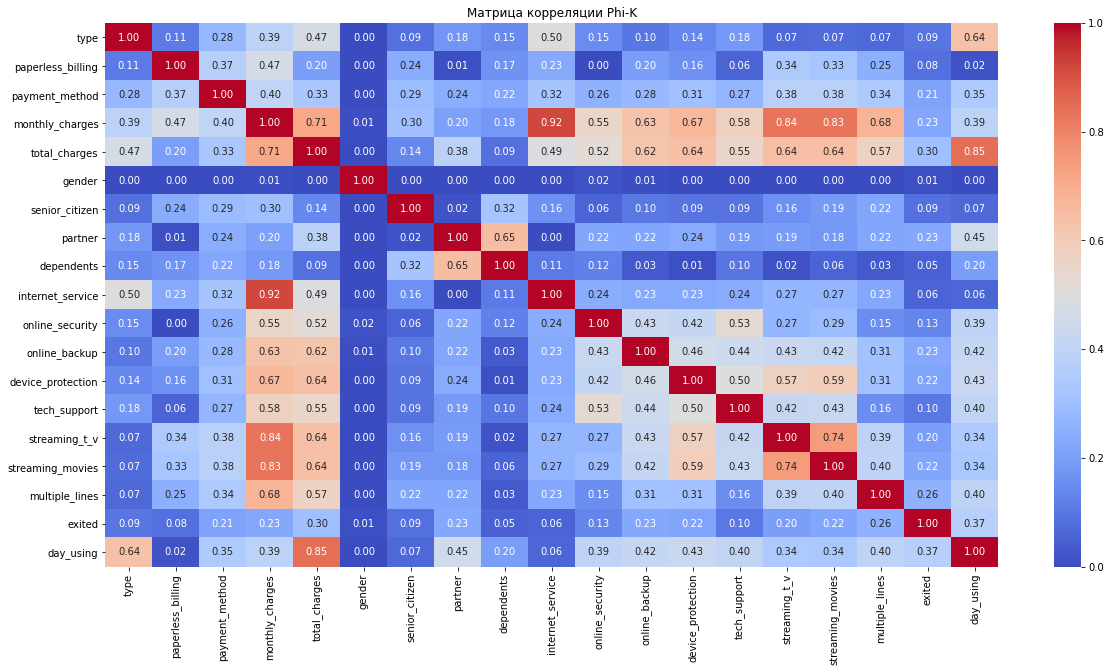

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции Phi-K')
plt.show()

- матрица показывает нам сильную корреляцию ежемесячных расходов и типа подключения интернета
- также в целом видим корреляцию между ежемесячными и общими расходами и признаками интернет сервисов
- также коррелируют общие расходы и количество дней пользования
- есть корреляция между ежемесячными и общими расходами
- также видим корреляции dependents и partner, streaming_t_v и streaming_movies

Посмотрим на важность признаков для нашего целевого признака с точки зрения корреляции Phik

In [ ]:
phik_overview['exited'].sort_values(ascending=False)

exited               1.000000
day_using            0.374101
total_charges        0.303758
multiple_lines       0.261345
online_backup        0.229736
partner              0.227597
monthly_charges      0.225823
streaming_movies     0.221756
device_protection    0.218622
payment_method       0.214300
streaming_t_v        0.200334
online_security      0.132914
tech_support         0.103933
type                 0.094622
senior_citizen       0.085708
paperless_billing    0.082789
internet_service     0.056279
dependents           0.048710
gender               0.008800
Name: exited, dtype: float64

Таким образом, мы отсортировали важность признаков, будем иметь ввиду эти значения для отбора признаков в модель

Далее посмотрим на распределения категориальных признаков

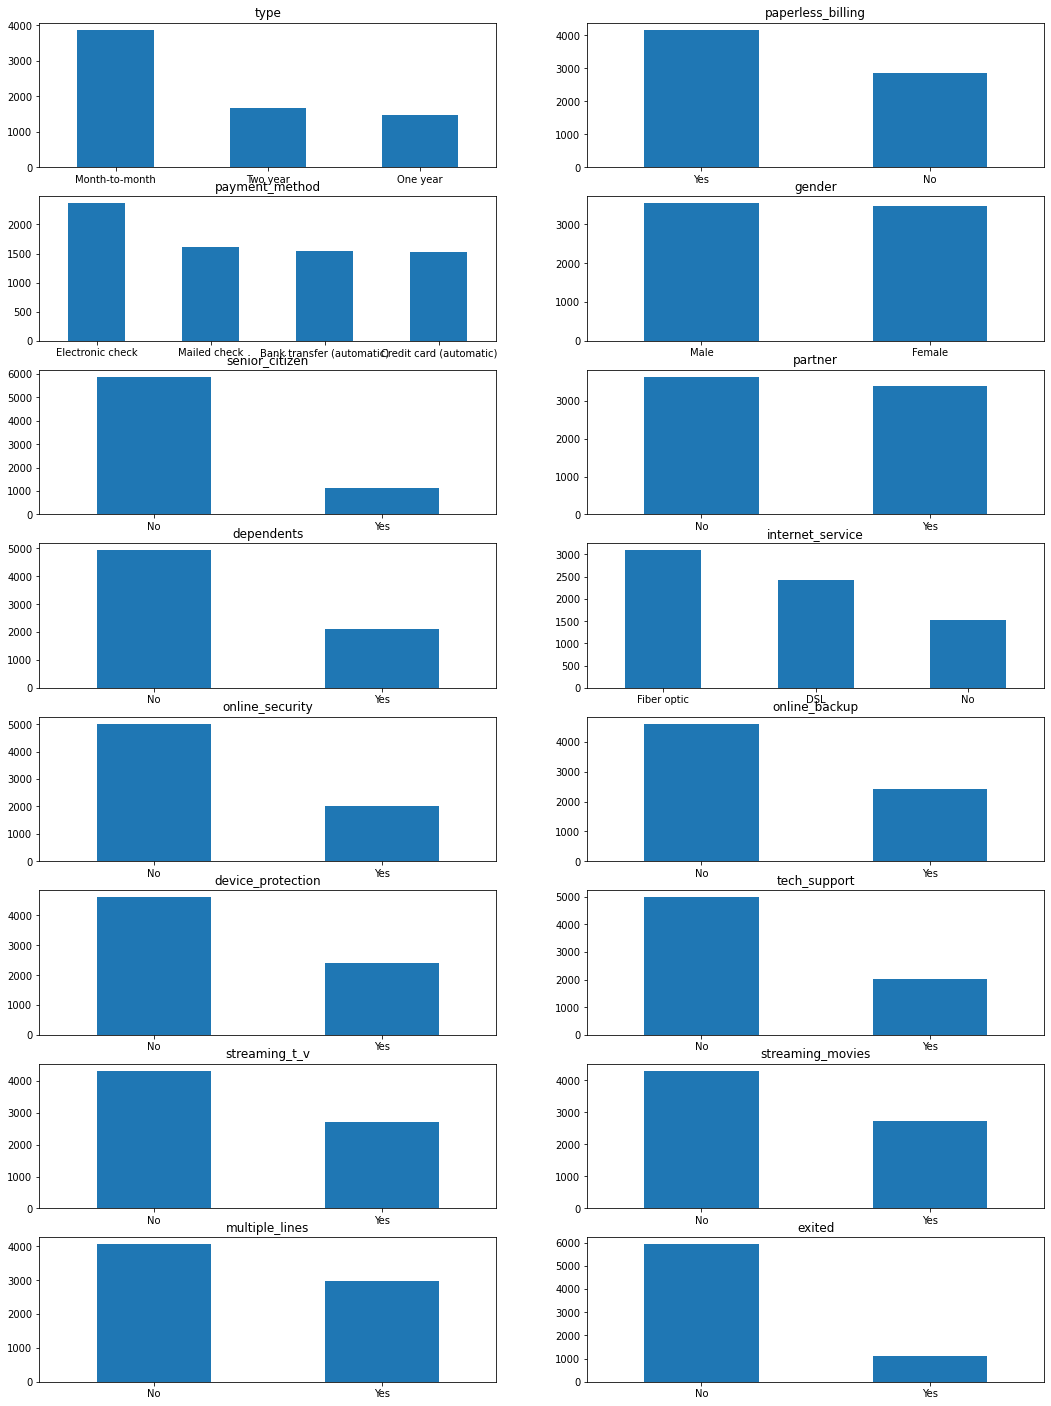

In [ ]:
plt.figure(figsize=(18, 25))

for idx, col in enumerate(categorial_features):
    ax = plt.subplot(int(np.ceil(len(categorial_features) / 2)), 2, idx + 1)

    df[col].value_counts().plot(kind='bar', title=col, ax=ax, rot=0)

plt.show()

- cамый популярный способ оплаты - ежемесячный
- клиенты в равной степени делятся на мужчин и женщин
- чаще счета на оплату получают в электронном виде, а оплачивают электронным чеком
- чаще дополнительные услуги не подключают

Посмотрим на распределение непрерывных признаков

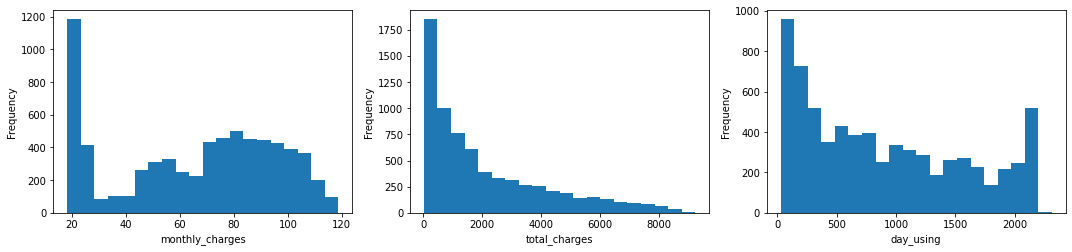

In [ ]:
plt.figure(figsize=(15, 10))

columns_to_plot = ['monthly_charges', 'total_charges', 'day_using']

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[col], bins=20)

    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()

plt.show()

In [ ]:
df[['monthly_charges', 'total_charges', 'day_using']].describe()

,monthly_charges,total_charges,day_using
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2118.621822,899.961320
std,30.085974,2112.736199,682.738777
min,18.250000,19.050000,28.000000
25%,35.587500,439.745000,276.000000
50%,70.350000,1345.275000,761.000000
75%,89.862500,3239.317500,1461.000000
max,118.750000,9221.380000,2314.000000


- у признака day_using имеется два пика - среди новых клиентов и среди лояльных, которые давно пользуются услугами
- у признака monthly_charges можно наблюдать бимодальность, когда ежемесячные траты минимальны ~ 20 и концентрируются вокруг значения 80, возможно существует фактор, влияющий на это
- у признака total_charges значения убывают

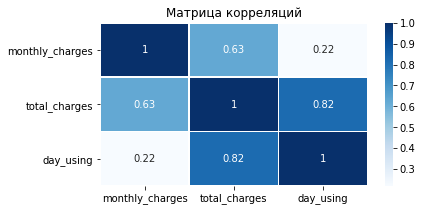

In [ ]:
correlation_matrix = df[num_features].corr()

plt.figure(figsize=(6, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5)
plt.title('Матрица корреляций')
plt.show()

Видим достаточно сильные корреляции признаков total_charges и day_using, что логично - чем дольше клиент пользуется услугами, тем выше сумма итоговых расходов

Удалим признаки, незначимые для построения модели

In [ ]:
df_model = df.drop(['customer_id', 'begin_date', 'end_date', 'gender', 'streaming_t_v', 'tech_support', 'online_backup'], axis=1)

In [ ]:
df_model.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,device_protection,streaming_movies,multiple_lines,exited,day_using
0,Month-to-month,Yes,Electronic check,29.85,31.04,No,Yes,No,DSL,No,No,No,No,No,31
1,One year,No,Mailed check,56.95,2071.84,No,No,No,DSL,Yes,Yes,No,No,No,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,No,No,No,DSL,Yes,No,No,No,No,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,No,No,No,DSL,Yes,Yes,No,No,No,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,No,No,No,Fiber optic,No,No,No,No,No,153


In [ ]:
df_model['exited'] = df_model['exited'].apply(lambda x: 1 if x == 'Yes' else 0)

Разделим датасет на 2 части в соотношении 75:25 (75% обучающая выборка, 25% тестовая)

In [ ]:
# создадим признаки
features = df_model.drop('exited', axis=1)
target = df_model['exited']

# создадим обучающую выборку и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

print(features_train.shape)
print(features_test.shape)

print(len(features_train) / len(df))
print(len(features_test) / len(df))

(5274, 14)
(1758, 14)
0.75
0.25


Приведем числовые признаки к единому масштабу, чтобы какой-либо из признаков не оказался более важен за счет масштаба, а не по объективным причинам.
Однако это потребуется не для всех моделей, поэтому создадим новые переменные

In [ ]:
features_train_scaler = features_train.copy()
features_test_scaler = features_test.copy()

features_train_encoder = features_train.copy()
features_test_encoder = features_test.copy()

In [ ]:
categorial_features = [x for x in categorial_features if x not in ['customer_id', 'begin_date', 'exited', 'gender', 'streaming_t_v', 'tech_support', 'online_backup']]

In [ ]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

features_train_encoder[categorial_features] = encoder.fit_transform(features_train_encoder[categorial_features])

print('Размер выборки:', features_train_encoder.shape)
display(features_train_encoder.head())

features_test_encoder[categorial_features] = encoder.transform(features_test_encoder[categorial_features])

print('Тестовая выборка:', features_test_encoder.shape)
display(features_test_encoder.head())

Размер выборки: (5274, 14)


,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,device_protection,streaming_movies,multiple_lines,day_using
4563,0.0,1.0,0.0,69.80,1493.72,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,610
461,0.0,1.0,0.0,69.45,143.07,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,59
5275,0.0,0.0,2.0,45.70,402.16,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,245
1186,1.0,1.0,2.0,104.85,4103.83,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1157
3344,0.0,1.0,3.0,44.15,176.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123


Тестовая выборка: (1758, 14)


,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,device_protection,streaming_movies,multiple_lines,day_using
6727,2.0,1.0,0.0,109.25,4772.04,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1277
2322,0.0,1.0,1.0,85.70,2295.05,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,792
4623,0.0,1.0,2.0,92.50,647.50,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,215
2432,0.0,0.0,2.0,61.40,429.80,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,215
6998,0.0,1.0,2.0,81.00,2252.61,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,822


In [ ]:
features_train_encoder_scaler = features_train_encoder.copy()
features_test_encoder_scaler = features_test_encoder.copy()

In [ ]:
scaler = StandardScaler()

features_train_encoder_scaler[num_features] = scaler.fit_transform(features_train_encoder_scaler[num_features])

print('Размер выборки:', features_train_encoder_scaler.shape)
display(features_train_encoder_scaler.head())

features_test_encoder_scaler[num_features] = scaler.transform(features_test_encoder_scaler[num_features])

print('Тестовая выборка:', features_test_encoder_scaler.shape)
display(features_test_encoder_scaler.head())

Размер выборки: (5274, 14)


,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,device_protection,streaming_movies,multiple_lines,day_using
4563,0.0,1.0,0.0,0.164162,-0.303474,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.433285
461,0.0,1.0,0.0,0.152492,-0.939718,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.238600
5275,0.0,0.0,2.0,-0.639418,-0.817669,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.966751
1186,1.0,1.0,2.0,1.332854,0.926056,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.366184
3344,0.0,1.0,3.0,-0.691101,-0.923923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.145061


Тестовая выборка: (1758, 14)


,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,device_protection,streaming_movies,multiple_lines,day_using
6727,2.0,1.0,0.0,1.479566,1.240826,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.541570
2322,0.0,1.0,1.0,0.694325,0.074004,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.167282
4623,0.0,1.0,2.0,0.921061,-0.702098,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.010598
2432,0.0,0.0,2.0,-0.115924,-0.804649,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.010598
6998,0.0,1.0,2.0,0.537610,0.054012,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-0.123436


In [ ]:
scaler = StandardScaler()

features_train_scaler[num_features] = scaler.fit_transform(features_train_scaler[num_features])

print('Размер выборки:', features_train_scaler.shape)
features_train_scaler.head()

features_test_scaler[num_features] = scaler.transform(features_test_scaler[num_features])

print('Тестовая выборка:', features_test_scaler.shape)
display(features_test_scaler.head())

Размер выборки: (5274, 14)
Тестовая выборка: (1758, 14)


,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,device_protection,streaming_movies,multiple_lines,day_using
6727,Two year,Yes,Bank transfer (automatic),1.479566,1.240826,No,Yes,No,Fiber optic,No,Yes,Yes,Yes,0.541570
2322,Month-to-month,Yes,Credit card (automatic),0.694325,0.074004,Yes,Yes,No,Fiber optic,No,Yes,No,No,-0.167282
4623,Month-to-month,Yes,Electronic check,0.921061,-0.702098,No,No,No,Fiber optic,No,Yes,No,Yes,-1.010598
2432,Month-to-month,No,Electronic check,-0.115924,-0.804649,No,No,No,DSL,Yes,Yes,No,No,-1.010598
6998,Month-to-month,Yes,Electronic check,0.537610,0.054012,No,No,No,Fiber optic,No,Yes,No,Yes,-0.123436


**Выводы:**
- привели имена столбцов к "змеиному" стилю
- объединили наборы данных в один
- пропуски в датафрейме после объединения в internet_service, online_security, online_backup, device_protection, tech_support, streaming_t_v, streaming_movies и multiple_lines заменили на отсутствующее значение (отсутствие сервиса)
- в наборе данных df_contract TotalCharges и BeginDate преобразовали типы данных
- обработали пропуски в total_charges
- обнаружили в целевом признаке end_date достаточно сильный дисбаланс классов - только 16% отражают факт ухода клиента
- сформировали портрет уходящего и лояльного клиента с помощью мер центральной тенденции по каждому признаку
- составили матрицу корреляций признаков, а также матрицу корреляций phik
- масштабировали числовые признаки monthly_charges и total_charges
- закодировали категориальные признаки с помощью OrdinalEncoder

## ML

Перед нами стоит задача классификации.

Обучать в нашем проекте будем следующие модели:

- LogisticRegression
- GradientBoostingClassifier
- CatBoostClassifier

In [ ]:
def GS_best_params(model,
                   params_grid,
                   features_train,
                   target_train,
                   cv_rate=8,
                   refit=True,
                   verbose=3,
                   n_jobs=-1):

    GS = GridSearchCV(model,
                      params_grid,
                      cv=5,
                      refit=refit,
                      scoring='roc_auc',
                      verbose=verbose,
                      n_jobs=n_jobs).fit(features_train, target_train)

    return GS

### LogisticRegression

In [ ]:
lr_time = time()

lr_model = LogisticRegression(random_state=RANDOM_STATE)

# Задание сетки параметров для поиска
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Параметр регуляризации
    'penalty': ['l1', 'l2'],  # Тип регуляризации
    'solver': ['liblinear', 'lbfgs', 'saga']  # Алгоритм оптимизации
}

# Создание объекта GridSearchCV с метрикой ROC AUC и кросс-валидацией
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(features_train_encoder_scaler, target_train)

lr_full_time = round(time() - lr_time, 2)

lr_roc_auc = round(grid_search.best_score_, 2)

print('Cross-val ROC AUC LogisticRegression:', lr_roc_auc)
print('Time:', lr_full_time)

Cross-val ROC AUC LogisticRegression: 0.75
Time: 35.22


### GradientBoostingClassifier

In [ ]:
gbc_time = time()

gbc_model = GradientBoostingClassifier(random_state=RANDOM_STATE)

gbc_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

gbc_gs = GS_best_params(gbc_model, gbc_params, features_train_encoder, target_train)

gbc_est = gbc_gs.best_estimator_

gbc_roc_auc = round(gbc_gs.best_score_, 2)

gbc_full_time = round(time() - gbc_time, 2)

print('Cross-val ROC-AUC GradientBoostingClassifier:', gbc_roc_auc)
print('GradientBoostingClassifier best_estimator:', gbc_est)
print('Time:', gbc_full_time)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.1s
[CV 2/5] END learning_rate=0.0

### CatBoostClassifier

In [ ]:
categorical_feature_indices = [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13]

cbc_time = time()

cbc_model = CatBoostClassifier(verbose=False, random_state=RANDOM_STATE, cat_features=categorical_feature_indices)

cbc_params = {'iterations': [400, 500],
              'learning_rate': [0.5],
              'depth': [3, 5]}

cbc_gs = GS_best_params(cbc_model, cbc_params, features_train, target_train)

cbc_est = cbc_gs.best_estimator_.get_params()

cbc_roc_auc = round(cbc_gs.best_score_, 2)

cbc_full_time = round(time() - cbc_time, 2)

print('Cross-val ROC-AUC CatBoostClassifier:', cbc_roc_auc)
print('CatBoostClassifier best_estimator:', cbc_est)
print('Time:', cbc_full_time)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....depth=3, iterations=400, learning_rate=0.5; total time=   2.7s
[CV 2/5] END .....depth=3, iterations=400, learning_rate=0.5; total time=   2.8s
[CV 3/5] END .....depth=3, iterations=400, learning_rate=0.5; total time=   2.9s
[CV 4/5] END .....depth=3, iterations=400, learning_rate=0.5; total time=   2.9s
[CV 5/5] END .....depth=3, iterations=400, learning_rate=0.5; total time=   2.9s
[CV 1/5] END .....depth=3, iterations=500, learning_rate=0.5; total time=   3.1s
[CV 2/5] END .....depth=3, iterations=500, learning_rate=0.5; total time=   3.4s
[CV 3/5] END .....depth=3, iterations=500, learning_rate=0.5; total time=   3.3s
[CV 4/5] END .....depth=3, iterations=500, learning_rate=0.5; total time=   3.4s
[CV 5/5] END .....depth=3, iterations=500, learning_rate=0.5; total time=   3.7s
[CV 1/5] END .....depth=5, iterations=400, learning_rate=0.5; total time=   3.7s
[CV 2/5] END .....depth=5, iterations=400, learni

**Промежуточные результаты обучения моделей**

In [ ]:
model_results = pd.DataFrame({'Model': ['LogisticRegression',
                                         'GradientBoostingClassifier',
                                         'CatBoostClassifier'],

                              'Cross-val ROC-AUC': [lr_roc_auc, gbc_roc_auc, cbc_roc_auc],

                              'Time (seconds)': [lr_full_time, gbc_full_time, cbc_full_time]})

model_results = model_results.sort_values(by='Cross-val ROC-AUC')
model_results

,Model,Cross-val ROC-AUC,Time (seconds)
0,LogisticRegression,0.75,35.22
1,GradientBoostingClassifier,0.91,110.63
2,CatBoostClassifier,0.94,67.34


**Выводы:**
- лидер среди моделей - CatBoostClassifier: лучше результат ROC-AUC на кросс-валидации по сравнению с другими моделями и оптимальное время подбора гиперпараметров. Её и выберем для тестирования

## Тестирование

In [ ]:
cbc_time = time()

# лучшая модель cbc_est для предсказаний на тестовой выборке
cbc_predictions = cbc_est.predict_proba(features_test)
cbc_predictions_one = cbc_predictions[:, 1]

# ROC AUC на тестовой выборке
cbc_roc_auc_test = roc_auc_score(target_test, cbc_predictions_one)

cbc_full_time = round(time() - cbc_time, 2)

print('Test ROC-AUC CatBoostClassifier:', cbc_roc_auc_test)
print('Time:', cbc_full_time)

Test ROC-AUC CatBoostClassifier: 0.9184159872494331
Time: 0.01


In [ ]:
cbc_preds = cbc_est.predict(features_test)

accuracy_cbc = accuracy_score(cbc_preds, target_test)
precision_cbc = precision_score(target_test, cbc_preds)
recall_cbc = recall_score(target_test, cbc_preds)
f1_score_cbc = f1_score(target_test, cbc_preds)

print('Accuracy score:', accuracy_cbc)
print('Precision score:', precision_cbc)
print('Recall score:', recall_cbc)
print('F1 score:', f1_score_cbc)

Accuracy score: 0.9453924914675768
Precision score: 0.9124423963133641
Recall score: 0.72
F1 score: 0.8048780487804879


- Accuracy score (Оценка точности): Значение составляет приблизительно 0.9454, что означает, что модель правильно классифицировала около 94.54% всех примеров в тестовой выборке.

- Precision score (Оценка точности предсказаний): Этот показатель равен приблизительно 0.9124, что говорит о том, что из всех предсказанных моделью положительных классов (клиенты, которые ушли), около 91.24% были действительно положительными, а остальные 8.76% ложно положительными.

- Recall score (Оценка полноты): Значение составляет примерно 0.72, что означает, что модель смогла обнаружить около 72% всех действительных положительных случаев (клиентов, которые ушли).

- F1 score (Гармоническое среднее между точностью и полнотой): Этот показатель равен приблизительно 0.8049, что является средним гармоническим между точностью и полнотой. Он используется для балансировки точности и полноты и предостерегает от переоценки модели, учитывая оба эти аспекта.

Исходя из этих результатов, модель имеет высокую точность и хороший показатель F1, но полнота немного ниже. Это значит, что модель имеет некоторые ложные отрицательные предсказания (может пропускать клиентов, которые уходят)

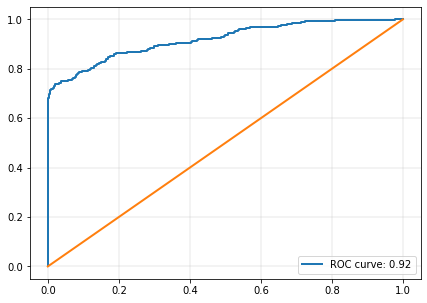

In [ ]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_test, cbc_predictions_one)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {cbc_roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

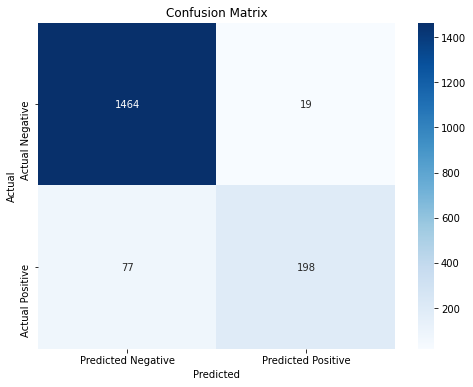

In [ ]:
# зададим пороговое значение
threshold = 0.5

# преобразуем вероятности в бинарные прогнозы
binary_predictions = np.where(cbc_predictions_one >= threshold, 1, 0)

# рассчитаем матрицу ошибок
confusion_mat = confusion_matrix(target_test, binary_predictions)

# тепловая карта (heatmap) для визуализации матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Feature importances

Перейдем к интерпретации модели и посмотрим на важность признаков (что важно для лучшей модели)

In [ ]:
cbc_est.get_feature_importance(prettified=True)

,Feature Id,Importances
0,day_using,50.753060
1,monthly_charges,14.249912
2,total_charges,12.237091
3,type,5.460607
4,payment_method,3.810298
5,internet_service,3.209733
6,device_protection,2.130549
7,partner,2.129307
8,multiple_lines,1.784377
9,dependents,1.376722


In [ ]:
cbc_est.get_feature_importance(prettified=True)['Feature Id'].to_list()

['day_using',
 'monthly_charges',
 'total_charges',
 'type',
 'payment_method',
 'internet_service',
 'device_protection',
 'partner',
 'multiple_lines',
 'dependents',
 'streaming_movies',
 'senior_citizen',
 'online_security',
 'paperless_billing']

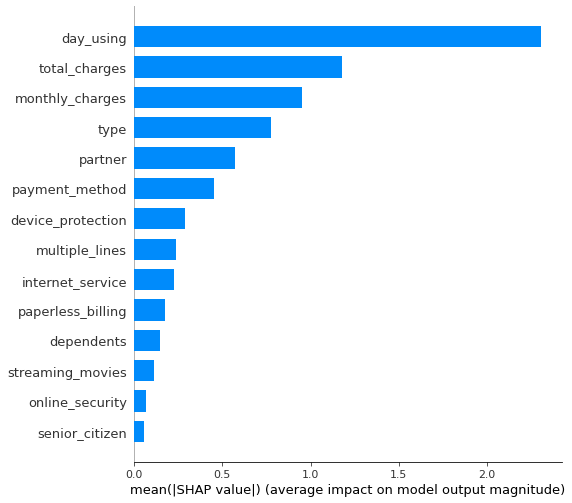

In [ ]:
explainer = shap.TreeExplainer(cbc_est)

# SHAP значения (SHAP values) для тестовых данных
shap_values = explainer.shap_values(features_test)

# важность признаков с помощью summary plot
shap.summary_plot(shap_values, features_test, plot_type="bar", show=False)

plt.show()

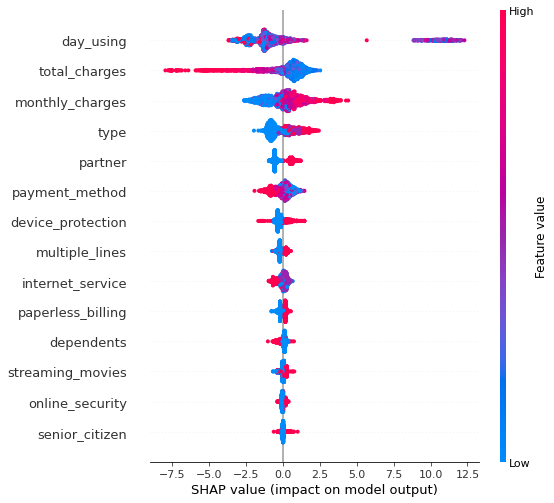

In [ ]:
# более детальная информация:
shap.summary_plot(shap_values, features_test_encoder, show=False)

plt.show()

- чем выше итоговые расходы за пользование сервисом, тем менее клиент склонен к оттоку; при этом, чем выже ежемесячные расходы, тем более клиент склонен к оттоку
- клиенты с ежемесячной подпиской менее склонны оттоку, чем клиенты в подпиской на 2 года
- клиенты без супругов менее склонны к оттоку
- клиенты с детьми также менее склонны к оттоку

Посмотрим на каждый признак в отдельности, чтобы ещё лучше понять как модель назначает score в зависимости от каждой переменной

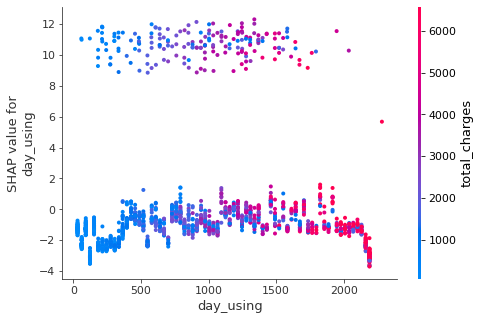

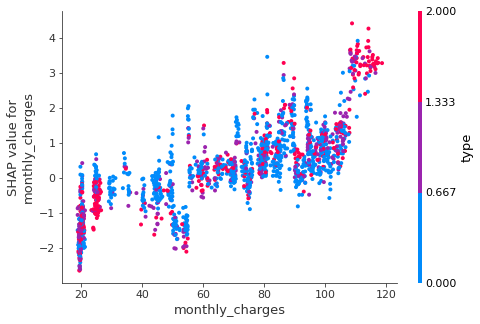

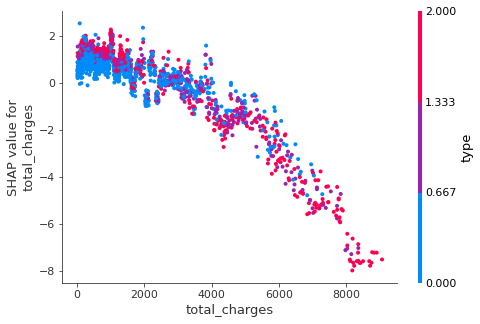

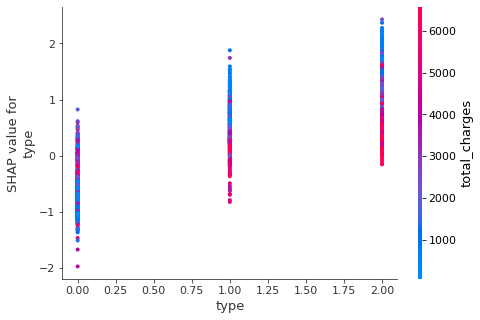

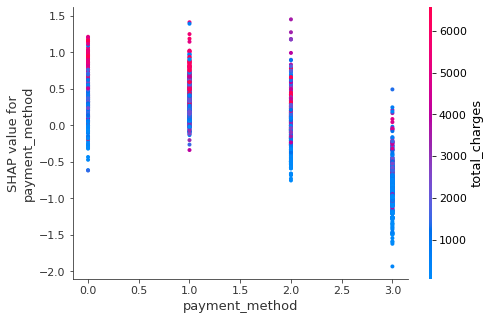

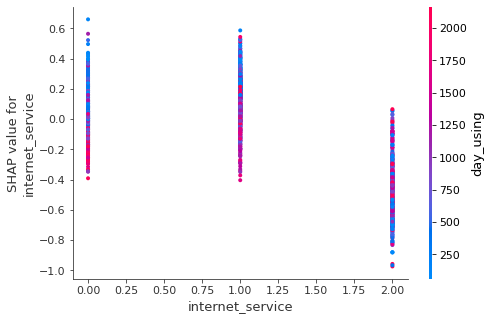

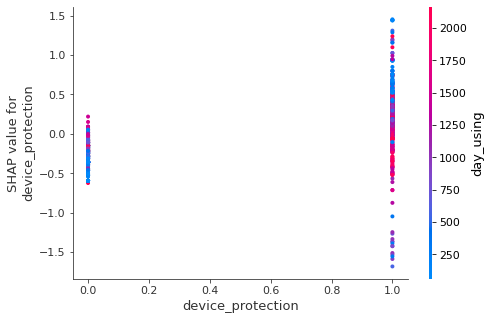

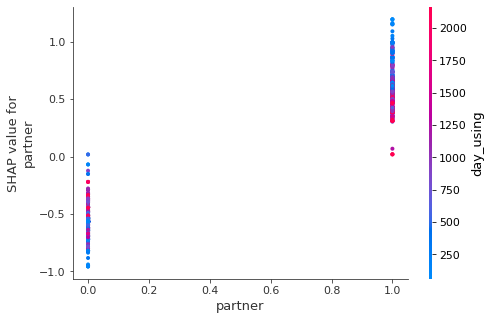

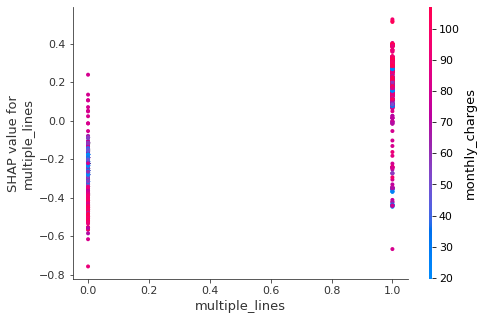

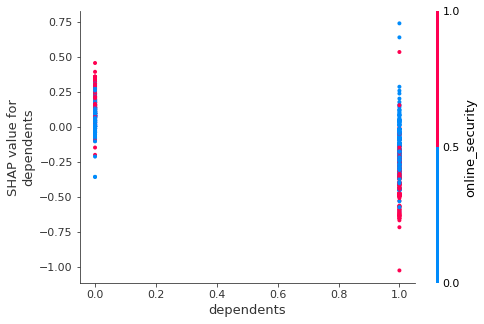

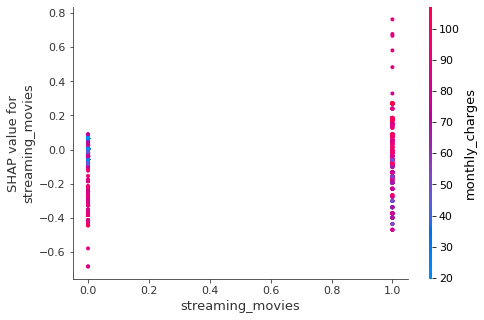

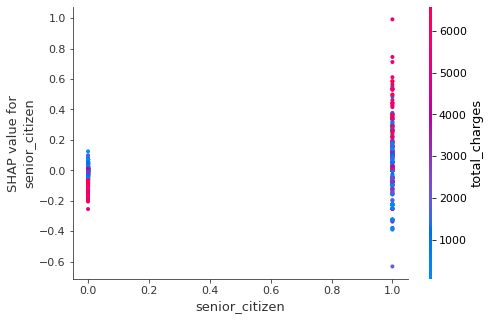

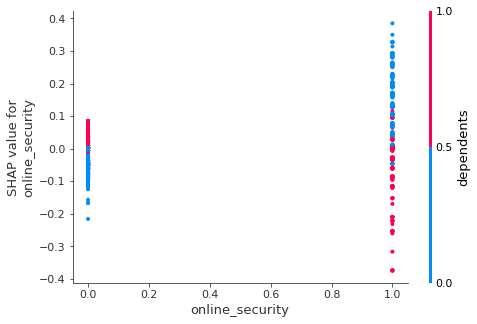

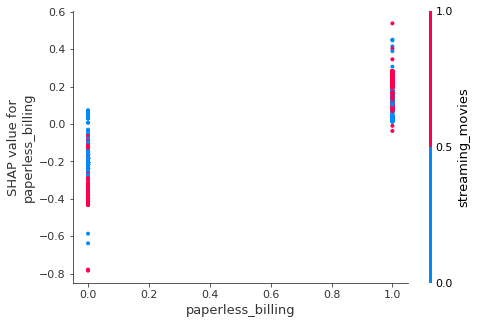

In [ ]:
features = cbc_est.get_feature_importance(prettified=True)['Feature Id'].values

for feature in features:
    shap.dependence_plot(feature, shap_values, features_test_encoder)

## Общие выводы по исследованию:

Для компании оператора связи «Ниединогоразрыва.ком» была разработана модель машинного обучения для прогнозирования оттока клиентов. Требовалось получить модель, которая на тестовой выборке покажет значение метрики ROC AUC не менее 0.85 - этого удалось достигнуть.

*Итого основные результаты по шагам проекта:*

- подготовка и анализ данных
  - импортированы необходимые библиотеки и загружены данные
  - данные из 4-х датафреймов объеденены в один
  - обработаны пропуски в данных после объединения наборов данных
  - проведена работа с типами данных
  - добавлен дополнительный признак количества дней использования сервиса
  - сформирован портрет уходящего и лояльного клиента с помощью мер центральной тенденции по каждому признаку
  - составлена матрица корреляций phik
  - отобраны признаки для машинного обучения
  - масштабировали числовые признаки monthly_charges и total_charges для модели логистической регрессии
  - закодировали категориальные признаки с помощью OrdinalEncoder для моделей логистической регрессии и GradientBoostingClassifier

- обучение моделей
  - данные согласно заданию были разделены на тренировочную и тестовую выборки (75/25)
  - обучены модели, подобраны гиперпараметры, подготовлена итоговая сводная таблица с результатами
  - GradientBoostingClassifier и CatBoostClassifier показали хорошие результаты требуемой метрики ROC-AUC на кросс-валидации, лучшей была выбрана модель CatBoostClassifier()


| Модель                        | Cross-val ROC-AUC | Time (sec) |
|-------------------------------|-----------------------------------------------|-----------------------------|
| LogisticRegression               | 0.75                                      | 35.22                      |
| GradientBoostingClassifier | 0.91                                      | 110.63                      |
| CatBoostClassifier                | 0.94 | 67.34                     |

- тестирование модели
  - значение ROC-AUC на тестовом наборе данных составило 0.91, что соответствует критерию заказчика
  - с помощью shap визуализировано важность и влияние каждого признака на предсказание модели
  - составлен список признаков, важных для модели - признаки: ['day_using',
 'monthly_charges',
 'total_charges',
 'type',
 'payment_method',
 'internet_service',
 'device_protection',
 'partner',
 'multiple_lines',
 'dependents',
 'streaming_movies',
 'senior_citizen',
 'online_security',
 'paperless_billing']
  
  
Таким образом, если модель предскажет, что пользователь планирует уйти, ему могут быть предложены промокоды и специальные условия